In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import pandas as pd
import numpy as np
import scattertext as st
from wordcloud import WordCloud, STOPWORDS
import scattertext as st
import nltk
import warnings
warnings.filterwarnings('ignore')

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet

In [3]:
PS = PorterStemmer()

In [4]:
import math
from sklearn.neighbors import NearestNeighbors

In [5]:
from fuzzywuzzy import fuzz
from sklearn.metrics.pairwise import cosine_similarity

## Constant Variable

In [6]:
data_path = 'liquor_data.csv'

## Data Exploration

In [7]:
def load_data(data_path):
    return pd.read_csv(data_path, encoding='utf-8')

In [8]:
df_initial = load_data(data_path)
df_initial.head()

,name,intl_name,brand_name,brand_intl_name,year_month,rank,score,f1,f2,f3,f4,f5,f6,flavour_tags,checkin_count,pictures,similar_brands,id
0,上川大雪,Kamikawataisetsu,北海道,Hokkaido,202001,1,4.299969,0.516103,0.484763,0.203029,0.419481,0.276085,0.453028,|グイグイ|メロン|フレッシュ|上品|丸み|フルーティ|旨味|甘味|酸味|マスカット|ガス|...,117,https://s3-ap-northeast-1.amazonaws.com/physal...,加茂錦|而今|陸奥八仙|宮寒梅|十四代,8685
1,國稀,Kunimare,北海道,Hokkaido,202001,2,4.099463,0.187750,0.304858,0.417155,0.539935,0.527491,0.357793,|辛口|蜜|スッキリ|力強い|旨味|ゴクゴク|洋梨|若い|じっくり|薄い|円やか|ちびちび|...,210,https://s3-ap-northeast-1.amazonaws.com/physal...,月山|黒牛|龍力|谷川岳|春鹿,1928
2,男山,Otokoyama,北海道,Hokkaido,202001,3,4.095614,0.277607,0.394435,0.327092,0.520835,0.454270,0.427476,|辛口|酸味|甘味|旨味|スッキリ|冷酒|常温|ヨーグルト|ヤクルト|熱燗|ひろがる|バラン...,397,https://s3-ap-northeast-1.amazonaws.com/physal...,春鹿|まんさくの花|酔鯨|加賀鳶|いづみ橋,2
3,国士無双,Kokushimuso,北海道,Hokkaido,202001,4,4.079436,0.387998,0.256487,0.161930,0.372511,0.593511,0.516169,|辛口|洋梨|ピリリ|フルーティ|荒々しい|スパイシー|さらり|果物|酸味|さわやか|スイス...,208,https://s3-ap-northeast-1.amazonaws.com/physal...,上喜元|酔心|澤乃井|加賀鳶|司牡丹,10
4,北の錦,Kitanonishiki,北海道,Hokkaido,202001,5,4.055023,0.344262,0.393210,0.501239,0.564264,0.211910,0.335154,|とろみ|荒々しい|力強い|ほのか|薄い|トロピカル|ヨーグルト|濃厚|苦味|チーズ|旨味|...,85,https://s3-ap-northeast-1.amazonaws.com/physal...,誠鏡|原田|龍力|旦|天の戸,11


In [9]:
tab_infor = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
tab_infor = tab_infor.append(pd.DataFrame(df_initial.isnull().sum(axis=0)).T.rename(index={0: 'null values'}))
tab_infor = tab_infor.append(pd.DataFrame(df_initial.isnull().sum(axis=0) * 100 / df_initial.shape[0]).T.rename(index={0: 'null % values'}))
tab_infor

,name,intl_name,brand_name,brand_intl_name,year_month,rank,score,f1,f2,f3,f4,f5,f6,flavour_tags,checkin_count,pictures,similar_brands,id
column type,object,object,object,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,object,int64,object,object,int64
null values,0,144,0,0,0,0,0,326,326,326,326,326,326,19,0,1,126,0
null % values,0,13.4328,0,0,0,0,0,30.4104,30.4104,30.4104,30.4104,30.4104,30.4104,1.77239,0,0.0932836,11.7537,0


In [21]:
key_tags = set()

for tags in df_initial['flavour_tags']:
    if tags is None or isinstance(tags, float): continue
    key_tags = key_tags.union(tags.split('|'))

In [22]:
key_tags = [s for s in key_tags if s]

In [23]:
def count_words(df, colone):
    key_counts = dict()
    key_occurence = []
    
    for s in key_tags:
        key_counts[s] = 0
    
    for row in df[colone]:
        if row is None or isinstance(row, float): continue
        for s in row.split('|'):
            if s in key_counts.keys(): key_counts[s] += 1
            else: key_counts[s] = 0
    
    for (k, v) in key_counts.items():
        key_occurence.append([k, v])
    key_occurence.sort(key = lambda x: x[1], reverse=True)
    
    return key_counts, key_occurence

In [24]:
key_counts, key_occurence = count_words(df_initial, 'flavour_tags')

## Duplicate values

In [25]:
df_duplicate = df_initial[df_initial['name'].map(df_initial.name.value_counts() > 1)]

In [26]:
def get_infor(gr):
    return gr.brand_name, gr.brand_name.count()

## Data preprocessing

In [27]:
def keytag_inventory(df, column='flavour_tags'):
    key_root = dict()
    key_select = dict()
    category_key = []
    
    for row in df[column]:
        if row is None or isinstance(row, float): continue
        
        for s in row.split('|'):
            if len(s) == 0: continue
            racine = PS.stem(s)
            
            if racine in key_root.keys():
                key_root[racine].add(s)
            else:
                key_root[racine] = {s}

    for s in key_root.keys():
        min_length = 1000
        
        for v in key_root[s]:
            if len(key_root[s]) > 1:
                if len(v) < min_length:
                    min_length = len(v)
                    ref = v
            else:
                ref = v
        category_key.append(ref)
        key_select[s] = ref
    
    return key_select, key_root, category_key

In [28]:
key_select, key_root, category_key = keytag_inventory(df_initial)

In [29]:
def keytag_replacement(df, key_select, root=False, column='flavour_tags'):
    df_new = df.copy()
    
    for index, row in df_new.iterrows():
        flavour_tags = row[column]
        
        if pd.isnull(flavour_tags): continue
        row_data = []
        for s in flavour_tags.split('|'):
            racine = PS.stem(s) if root else s
            
            if racine is key_select.keys():
                row_data.append(key_select[racine])
            else:
                row_data.append(s)
                
        df_new.at[index, column] = '|'.join(row_data)
    return df_new

In [30]:
df_keywords_cleaned = keytag_replacement(df_initial, key_select, root=True)

In [31]:
key_counts, key_occurence = count_words(df_initial, 'flavour_tags')

## Finding synonyms

In [32]:
df_initial.flavour_tags.values[1]

'|辛口|蜜|スッキリ|力強い|旨味|ゴクゴク|洋梨|若い|じっくり|薄い|円やか|ちびちび|酸味|深み|苦味|まろやか|複雑|まったり|しっかり|柔らかい'

In [33]:
df_keywords_cleaned.flavour_tags.values[1]

'|辛口|蜜|スッキリ|力強い|旨味|ゴクゴク|洋梨|若い|じっくり|薄い|円やか|ちびちび|酸味|深み|苦味|まろやか|複雑|まったり|しっかり|柔らかい'

## Filling missing values

In [34]:
df_missing = pd.DataFrame(df_keywords_cleaned.isnull().sum(axis=0)).reset_index()
df_missing.columns = ['column_name', 'value_null']
df_missing['filling_factor'] = (df_keywords_cleaned.shape[0] - df_missing['value_null'])/df_keywords_cleaned.shape[0] * 100

In [35]:
df_missing

,column_name,value_null,filling_factor
0,name,0,100.000000
1,intl_name,144,86.567164
2,brand_name,0,100.000000
3,brand_intl_name,0,100.000000
4,year_month,0,100.000000
5,rank,0,100.000000
6,score,0,100.000000
7,f1,326,69.589552
8,f2,326,69.589552
9,f3,326,69.589552


In [36]:
df_duplicate_index = df_duplicate.index
df_duplicate_index

Int64Index([   8,   15,   66,   71,   81,   83,   84,   85,   89,   95,  115,
             121,  122,  132,  169,  187,  220,  243,  248,  375,  382,  395,
             441,  450,  466,  480,  483,  485,  487,  519,  521,  535,  536,
             579,  591,  616,  619,  627,  628,  636,  640,  817,  824,  845,
             852,  855,  860,  862,  863,  870,  874,  875,  877,  890,  908,
             911,  916,  935,  948,  992, 1002, 1018],
           dtype='int64')

In [46]:
df_keywords_cleaned[df_keywords_cleaned.f1.notnull() & df_keywords_cleaned.flavour_tags.isnull()].shape

(3, 18)

In [47]:
# df_initial.iloc[df_duplicate_index]

In [48]:
def get_infor(gr):
    flavour_tags = set()
    for ft in gr.flavour_tags.values:
        if ft is None or isinstance(ft, float): continue
        flavour_tags = flavour_tags.union(ft)
    
    return pd.DataFrame({'count': gr.shape[0], 
                         'intl_name': gr.intl_name,
                         'brand_name': gr.brand_name,
                         'f1_mean': gr.f1.mean(),
                         'f2_mean': gr.f2.mean(),
                         'f3_mean': gr.f3.mean(),
                         'f4_mean': gr.f4.mean(),
                         'f5_mean': gr.f5.mean(),
                         'f6_mean': gr.f6.mean(),
                         'flavour_tags': '|'.join(flavour_tags)})

In [49]:
df_groupby_name = df_keywords_cleaned.groupby(['brand_name']).apply(get_infor)

In [50]:
# df_groupby_name[df_groupby_name['brand_name'].map(df_groupby_name['brand_name'].value_counts() > 1)]

In [51]:
df_groupby_name.drop_duplicates(subset=['brand_name'], keep='first', inplace=True)

In [52]:
df_groupby_name

,count,intl_name,brand_name,f1_mean,f2_mean,f3_mean,f4_mean,f5_mean,f6_mean,flavour_tags
0,18,Kamikawataisetsu,北海道,0.341795,0.345148,0.308429,0.501827,0.406634,0.424070,味|ト|ク|ど|ひ|ン|苦|地|紹|こ|ワ|よ|み|洋|力|え|渋|と|さ|レ|グ|く|パ|...
18,20,Denshu,青森県,0.419480,0.366682,0.270643,0.434889,0.400226,0.424564,味|ト|ク|ど|ひ|ン|苦|地|醇|ネ|ワ|よ|み|洋|力|え|ご|渋|さ|レ|グ|く|温|...
38,27,Akabu,岩手県,0.381915,0.377337,0.290159,0.494317,0.354924,0.442487,味|ト|ク|ど|ン|苦|地|醇|ネ|紹|プ|ワ|よ|み|洋|力|え|と|渋|ご|さ|レ|グ|...
65,40,Hakurakusei,宮城県,0.398296,0.324573,0.223992,0.458690,0.396101,0.487848,味|ト|ク|ど|ひ|ン|苦|地|醇|ネ|プ|ワ|よ|み|洋|力|え|ご|と|渋|さ|レ|グ|...
105,48,Aramasa,秋田県,0.439692,0.379297,0.264462,0.410676,0.347653,0.469970,味|ト|ク|ど|ン|苦|地|醇|ネ|紹|プ|こ|ワ|よ|み|洋|力|え|渋|ご|と|さ|レ|...
153,50,Juyondai,山形県,0.395962,0.351485,0.264273,0.437188,0.388870,0.472020,味|ト|ク|ど|ン|苦|地|醇|ネ|紹|プ|ワ|よ|み|洋|ヒ|力|え|と|渋|ご|さ|レ|...
203,50,Sharaku,福島県,0.412586,0.408776,0.330975,0.447220,0.325856,0.443590,味|ト|ク|ど|ひ|ン|苦|地|醇|ネ|プ|こ|ワ|よ|み|ヒ|力|と|渋|え|さ|レ|グ|...
253,19,Raifuku,茨城県,0.434299,0.361421,0.309971,0.425188,0.336580,0.454949,味|ト|ど|ク|ン|苦|地|醇|ネ|プ|ワ|よ|み|洋|と|ご|渋|え|さ|レ|グ|く|パ|...
272,29,Hououbiden,栃木県,0.440722,0.430672,0.337885,0.349816,0.303854,0.464663,味|ト|ク|ど|ン|苦|醇|ネ|紹|プ|こ|ワ|よ|み|ヒ|力|え|ご|渋|と|さ|レ|グ|...
301,22,Oze no Yukidoke,群馬県,0.448157,0.353160,0.247149,0.348089,0.383715,0.529682,味|ト|ク|ど|ン|苦|地|醇|ネ|プ|こ|ワ|よ|み|洋|力|と|ご|渋|え|さ|レ|グ|...


## Plot by group

In [53]:
import seaborn as sb

In [54]:
# df_keywords_cleaned[df_keywords_cleaned.f1.isnull()].shape

In [55]:
def is_valid(var):
    return (var is not None and not isinstance(var, float))

In [56]:
def is_same_flavour_tags(fl_tag, main_fl_tag):
    if pd.isnull(fl_tag): return False
    return (fuzz.ratio(fl_tag, main_fl_tag) > 50)

In [57]:
def filling_missing_factor(df, df_group):
    df_new = df.copy()
    
    for index, row in df_new.iterrows():
        brand_name = row['brand_name']
        intl_name = row['intl_name']
        flavour_tags = row['flavour_tags']
        f1 = float(row['f1'])
        f2 = float(row['f2'])
        f3 = float(row['f3'])
        f4 = float(row['f4'])
        f5 = float(row['f5'])
        f6 = float(row['f6'])
        
        if ((is_valid(intl_name)) and (is_valid(flavour_tags)) and
            (pd.notnull(f1)) and (pd.notnull(f2)) and (pd.notnull(f3)) and 
            (pd.notnull(f4)) and (pd.notnull(f5)) and (pd.notnull(f6))): continue
            
        if ((not ((is_valid(intl_name)) and (is_valid(flavour_tags)) and
            (pd.notnull(f1)) and (pd.notnull(f2)) and (pd.notnull(f3)) and 
            (pd.notnull(f4)) and (pd.notnull(f5)) and (pd.notnull(f6)))) or 
            (not (not is_valid(flavour_tags) and pd.notnull(f1)))):
            
            brand_record = df_group[df_group['brand_name'] == brand_name]

            if intl_name is None or isinstance(intl_name, float):
                value = brand_record['intl_name'].values[0]
                df_new.at[index, 'intl_name'] = value

            if flavour_tags is None or isinstance(flavour_tags, float):
                value = brand_record['flavour_tags'].values[0]
                df_new.at[index, 'flavour_tags'] = value

            if f1 is None or isinstance(f1, float):
                value = brand_record['f1_mean'].values[0]
                df_new.at[index, 'f1'] = value

            if f2 is None or isinstance(f2, float):
                value = brand_record['f2_mean'].values[0]
                df_new.at[index, 'f2'] = value

            if f3 is None or isinstance(f3, float):
                value = brand_record['f3_mean'].values[0]
                df_new.at[index, 'f3'] = value

            if f4 is None or isinstance(f4, float):
                value = brand_record['f4_mean'].values[0]
                df_new.at[index, 'f4'] = value

            if f5 is None or isinstance(f5, float):
                value = brand_record['f5_mean'].values[0]
                df_new.at[index, 'f5'] = value

            if f6 is None or isinstance(f6, float):
                value = brand_record['f6_mean'].values[0]
                df_new.at[index, 'f6'] = value
            
        if (is_valid(flavour_tags) and pd.isnull(f1)):
            group_records = df_new[df_new['flavour_tags'].apply(lambda x: is_same_flavour_tags(x, flavour_tags))]
            f1_mean = group_records['f1'].mean()
            f2_mean = group_records['f2'].mean()
            f3_mean = group_records['f3'].mean()
            f4_mean = group_records['f4'].mean()
            f5_mean = group_records['f5'].mean()
            f6_mean = group_records['f6'].mean()
            
            flavour_columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
            for f_i in flavour_columns:
                df_new.at[index, f_i] = eval('{}_mean'.format(f_i))

    return df_new

In [58]:
# df_keywords_cleaned[fuzz(df_keywords_cleaned['flavour_tags'], df_keywords_cleaned.iloc[1]['flavour_tags']) > 50]

In [59]:
df_filling = filling_missing_factor(df_keywords_cleaned, df_groupby_name)

In [60]:
df_filling[df_filling.f1.duplicated()]

,name,intl_name,brand_name,brand_intl_name,year_month,rank,score,f1,f2,f3,f4,f5,f6,flavour_tags,checkin_count,pictures,similar_brands,id
11,風のささやき,Kazenosasayaki,北海道,Hokkaido,202001,12,4.011301,0.341795,0.345148,0.308429,0.501827,0.406634,0.424070,|さらり|優しい|軽快|常温|さっぱり|辛口|旨味|スッキリ|酸味,14,https://s3-ap-northeast-1.amazonaws.com/physal...,NaN,8
12,十一州,Kamikawataisetsu,北海道,Hokkaido,202001,13,4.009420,0.341795,0.345148,0.308429,0.501827,0.406634,0.424070,|昔ながら|控えめ|甘味|穏やか|常温|さっぱり|上品|キリリ|苦味|軽快|余韻|フルーティ...,44,https://s3-ap-northeast-1.amazonaws.com/physal...,松みどり|聖泉|田酒|黎明|豊盃,2309
13,まる田,Maruta,北海道,Hokkaido,202001,14,4.009420,0.341795,0.345148,0.308429,0.501827,0.406634,0.424070,|あっさり|コク|薄い|さらり|熱燗|上品|バランス|キレ|常温|濃厚|スッキリ|酸味|しっ...,20,https://s3-ap-northeast-1.amazonaws.com/physal...,湊屋藤助|ん|大七|天領|義侠,1275
16,宝川,Takaragawa,北海道,Hokkaido,202001,17,4.007886,0.341795,0.345148,0.308429,0.501827,0.406634,0.424070,|芳香|洋梨|派手|力強い|キリリ|心地よい|優しい|ワイン|旨味|キレ|しっかり|スッキリ...,33,https://s3-ap-northeast-1.amazonaws.com/physal...,田むら|蒼田|佐藤卯兵衛|千代の園|浪乃音,4
17,田中酒造,Kamikawataisetsu,北海道,Hokkaido,202001,18,4.007886,0.341795,0.345148,0.308429,0.501827,0.406634,0.424070,|昔ながら|バランス|フルーティ,8,https://s3-ap-northeast-1.amazonaws.com/physal...,NaN,1848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,四万十川,Shimantogawa,高知県,Kochi,202001,14,4.006832,0.421285,0.315115,0.201756,0.340678,0.467328,0.531827,|硬い|ラムネ|スイスイ|ジュース|バナナ|ツン|あっさり|スッキリ|さらり|なめらか|芳醇...,63,https://s3-ap-northeast-1.amazonaws.com/physal...,文佳人|上善如水|北島|〆張鶴|越乃寒梅,944
1013,綾花,Ayaka,福岡県,Fukuoka,202001,18,4.009107,0.421374,0.318138,0.267922,0.395653,0.407910,0.479051,|マスカット|チョコレート|渋み|甘酸っぱい|あっさり|薄い|常温|キリリ|柔らかい|ふんわ...,78,https://s3-ap-northeast-1.amazonaws.com/physal...,青煌|水尾|立山|天領盃|旦,958
1014,花の露,Tanakarokujugo,福岡県,Fukuoka,202001,19,4.008826,0.421374,0.318138,0.267922,0.395653,0.407910,0.479051,|荒々しい|鮮烈|みずみずしい|ちびちび|上品|冷酒|フルーティ|柔らかい|優しい|綺麗|ま...,39,https://s3-ap-northeast-1.amazonaws.com/physal...,越乃雪椿|古伊万里|北雪|萩乃露|千駒,1941
1015,田中65,tanaka65,福岡県,Fukuoka,202001,20,4.008826,0.421374,0.318138,0.267922,0.395653,0.407910,0.479051,|ブドウ|みずみずしい|バナナ|チーズ|ほのか|酸味|スッキリ|ガス|上品|柔らかい|冷酒|...,50,https://s3-ap-northeast-1.amazonaws.com/physal...,津島屋|古伊万里|道灌|篠峯|田中六五,3452


## Implement Algorithm

In [61]:
# df_filling[df_filling.intl_name.isnull()].iloc[0]['brand_name']

In [62]:
def parse_datetime(date):
    date = str(date).strip()
    return date[:4] + '/' + date[4:]

In [63]:
df_filling['year_month'] = df_filling['year_month'].apply(parse_datetime)

In [64]:
df_filling['year'] = pd.to_datetime(df_filling['year_month']).apply(lambda x: x.year)

In [65]:
df_filling

,name,intl_name,brand_name,brand_intl_name,year_month,rank,score,f1,f2,f3,f4,f5,f6,flavour_tags,checkin_count,pictures,similar_brands,id,year
0,上川大雪,Kamikawataisetsu,北海道,Hokkaido,2020/01,1,4.299969,0.516103,0.484763,0.203029,0.419481,0.276085,0.453028,|グイグイ|メロン|フレッシュ|上品|丸み|フルーティ|旨味|甘味|酸味|マスカット|ガス|...,117,https://s3-ap-northeast-1.amazonaws.com/physal...,加茂錦|而今|陸奥八仙|宮寒梅|十四代,8685,2020
1,國稀,Kunimare,北海道,Hokkaido,2020/01,2,4.099463,0.187750,0.304858,0.417155,0.539935,0.527491,0.357793,|辛口|蜜|スッキリ|力強い|旨味|ゴクゴク|洋梨|若い|じっくり|薄い|円やか|ちびちび|...,210,https://s3-ap-northeast-1.amazonaws.com/physal...,月山|黒牛|龍力|谷川岳|春鹿,1928,2020
2,男山,Otokoyama,北海道,Hokkaido,2020/01,3,4.095614,0.277607,0.394435,0.327092,0.520835,0.454270,0.427476,|辛口|酸味|甘味|旨味|スッキリ|冷酒|常温|ヨーグルト|ヤクルト|熱燗|ひろがる|バラン...,397,https://s3-ap-northeast-1.amazonaws.com/physal...,春鹿|まんさくの花|酔鯨|加賀鳶|いづみ橋,2,2020
3,国士無双,Kokushimuso,北海道,Hokkaido,2020/01,4,4.079436,0.387998,0.256487,0.161930,0.372511,0.593511,0.516169,|辛口|洋梨|ピリリ|フルーティ|荒々しい|スパイシー|さらり|果物|酸味|さわやか|スイス...,208,https://s3-ap-northeast-1.amazonaws.com/physal...,上喜元|酔心|澤乃井|加賀鳶|司牡丹,10,2020
4,北の錦,Kitanonishiki,北海道,Hokkaido,2020/01,5,4.055023,0.344262,0.393210,0.501239,0.564264,0.211910,0.335154,|とろみ|荒々しい|力強い|ほのか|薄い|トロピカル|ヨーグルト|濃厚|苦味|チーズ|旨味|...,85,https://s3-ap-northeast-1.amazonaws.com/physal...,誠鏡|原田|龍力|旦|天の戸,11,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,山水,Sansui,大分県,Oita,2020/01,7,4.007098,0.375790,0.384162,0.315194,0.446610,0.364436,0.433070,|冷酒|穏やか|酸味|甘味,8,https://s3-ap-northeast-1.amazonaws.com/physal...,NaN,989,2020
1068,一の井手,Ichinoide,大分県,Oita,2020/01,8,4.007098,0.375335,0.384969,0.319049,0.451702,0.363577,0.428291,|柑橘|ピリリ|なめらか|熱燗|穏やか|ほのか|さわやか|苦味|しっかり|甘味|酸味|辛口,14,https://s3-ap-northeast-1.amazonaws.com/physal...,花美蔵|かもみどり|宮の雪|辨天|朝日山,991,2020
1069,千徳,Sentoku,宮崎県,Miyazaki,2020/01,1,4.412219,0.218945,0.400323,0.359828,0.667378,0.323975,0.334628,|カラメル|淡い|円やか|熱燗|常温|余韻|ヨーグルト|冷酒|あっさり|じっくり|さっぱり|...,91,https://s3-ap-northeast-1.amazonaws.com/physal...,玉川|英勲|志太泉|菊姫|昇龍蓬莱,1001,2020
1070,夢の中まで,夢の中まで,宮崎県,Miyazaki,2020/01,2,4.306894,0.366501,0.376070,0.310064,0.485180,0.353975,0.427725,|グイグイ|ブドウ|あっさり|柔らかい|フレッシュ|軽快|穏やか|苦味|フルーティ|旨味|甘...,20,https://s3-ap-northeast-1.amazonaws.com/physal...,天遊琳|長者盛|萩錦|仁淀ブルー|ほしいずみ,3486,2020


In [66]:
gaussian_filter = lambda x,y,sigma: math.exp(-(x-y)**2/(2*sigma**2))

In [67]:
# Function return variables selected from entry_id

def entry_variables(df, id_entry):
    col_labels = []
    
    if pd.notnull(df['brand_name'].iloc[id_entry]):
#         for s in df['brand_name'].iloc[id_entry].split('|'):
        col_labels.append(df['brand_name'].iloc[id_entry])
    
    if pd.notnull(df['flavour_tags'].iloc[id_entry]):
        for s in df['flavour_tags'].iloc[id_entry].split('|'):
            col_labels.append(s)
        
    return col_labels

In [47]:
def add_variables(df, REF_VAR):
    for s in REF_VAR: df[s] = pd.Series([0 for _ in range(len(df))])
        
#     columns = ['brand_name', 'flavour_tags']
    columns = ['flavour_tags']
    
    for index, row in df.iterrows():
        for category in columns:
            if pd.isnull(row[category]): continue
            data = row[category]
            if index == 'brand_name':
                if data in REF_VAR: df.at[index, data] = 1
            else:
                for s in data.split('|'):
                    if s in REF_VAR: df.at[index, s] = 1
    return df

In [48]:
df_filling.shape

(1072, 16)

In [49]:
# Function create N liquors similar with liquor given by user
import pickle
N_liquors = 33

def recommand(df, id_entry, N_liquors):
    df_copy = df.copy(deep=True)
    variables = entry_variables(df_copy, id_entry)
    df_new = add_variables(df_copy, variables)
    
    X = df_new.as_matrix(variables)
    nbrs = NearestNeighbors(n_neighbors=N_liquors, algorithm='auto', metric='euclidean').fit(X)
#     knn_pickle_file = open('knn_pickle_file', 'wb')
#     pickle.dump(nbrs, knn_pickle_file)
#     nbrs = pickle.load(open('knn_pickle_file', 'rb'))
    distances, indices = nbrs.kneighbors(X)
    x_test = df_new.iloc[id_entry].as_matrix(variables)
    x_test = x_test.reshape(1, -1)
    distances, indices = nbrs.kneighbors(x_test)

#     cosine_matrix = cosine_similarity(X, X)
#     indices = pd.Series(cosine_matrix[id_entry])
#     top_10 = indices.sort_values(ascending=False).iloc[1:11].index
#     recommend_ids = []
    
#     for i in top_10:
#         recommend_ids.append(list(df_copy.index)[i])
    
    return indices[0][:]

In [50]:
def sequel(brand_1, brand_2):
    return (fuzz.ratio(brand_1, brand_2) > 50 or fuzz.token_set_ratio(brand_1, brand_2) > 50)

In [51]:
#Function give a mark to a liquor

# def critere_selection(brand_main, year_ref, max_checkin, score, f1, f2, 
#                       f3, f4, f5, f6, year, brand, checkin_count):
#     if pd.notnull(year_ref):
#         facture_1 = gaussian_filter(int(year_ref), int(year), 2020)
#     else:
#         facture_1 = 1
    
#     sigma = max_checkin * 1.0
#     if pd.notnull(max_checkin):
#         facture_2 = gaussian_filter(int(max_checkin), int(checkin_count), sigma)
#     else:
#         facture_2 = 1
    
#     if not sequel(brand_main, brand):
#         note = 0
#     else:
#         f1 *= 10
#         f2 *= 10
#         f3 *= 10
#         f4 *= 10
#         f5 *= 10
#         f6 *= 10
#         note = score**2 * f1**2 * f2**2 * f3**2 * f4**2 * f5**2 * f6**2 * facture_1 * facture_2 
#     return note

In [52]:
#Function give a mark to a liquor

def new_critere_selection(brand_main, year_ref, max_checkin, score, f1, f2, f3, f4, f5, f6, 
                          year, brand, checkin_count, max_f1, max_f2, max_f3, max_f4, max_f5, max_f6):
    if pd.notnull(year_ref):
        facture_1 = gaussian_filter(int(year_ref), int(year), 2020)
    else:
        facture_1 = 1
    
    sigma = (max_checkin * 1.0)
    if pd.notnull(max_checkin):
        facture_2 = gaussian_filter(int(max_checkin), int(checkin_count), sigma)
    else:
        facture_2 = 1
        
#     sigma_flavour = max(max_f1, max_f2, max_f3, max_f4, max_f5, max_f6) * 1.0
    sigma_flavour = 0.6
    flavour_columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
    for i in range(len(flavour_columns)):
#         print(globals()['max_{}'.format(flavour_columns[i])])
        globals()['facture_{}'.format(i+3)] = gaussian_filter(float(eval('max_{}'.format(flavour_columns[i]))),
                                                              float(eval('{}'.format(flavour_columns[i]))), sigma_flavour)
    
#     if not sequel(brand_main, brand):
#         note = 0
#     else:
#         f1 *= 10
#         f2 *= 10
#         f3 *= 10
#         f4 *= 10
#         f5 *= 10
#         f6 *= 10
    note = facture_1 + facture_2 + (facture_3 + facture_4 + facture_5 + facture_6 + facture_7 + facture_8)*7
         
#     print(note)
    
    return note

In [53]:
# gaussian_filter(0.2, 0.23, 1)

In [54]:
# def extract_parameters(df, list_liquors, N_liquors):
#     list_paramerters = ['_' for _ in range(len(list_liquors))]
#     max_checkin = -1
    
#     for i, index in enumerate(list_liquors):
#         list_paramerters[i] = list(df.iloc[index][['brand_name', 'score', 'f1', 'f2', 'f3', 
#                                                    'f4', 'f5', 'f6', 'year', 'name', 'checkin_count']])
#         max_checkin = max(max_checkin, int(list_paramerters[i][10]))

#     brand_main = list_paramerters[0][0]
#     year_ref = list_paramerters[0][8]
    
#     list_paramerters.sort(key=lambda x: critere_selection(brand_main, year_ref, max_checkin, x[1], x[2],
#                                                           x[3], x[4], x[5], x[6], x[7], x[8], 
#                                                           x[0], x[10]), reverse=True)
    
#     return list_paramerters

In [55]:
def new_extract_parameters(df, list_liquors, N_liquors):
    list_paramerters = ['_' for _ in range(N_liquors)]
    i = 0
    max_checkin = -1
    max_f1 = -1
    max_f2 = -1
    max_f3 = -1
    max_f4 = -1
    max_f5 = -1
    max_f6 = -1
    
    for index in list_liquors:
        list_paramerters[i] = list(df.iloc[index][['brand_name', 'score', 'f1', 'f2', 'f3', 
                                                   'f4', 'f5', 'f6', 'year', 'name', 'checkin_count']])
        list_paramerters[i].append(index)
        max_checkin = max(max_checkin, int(list_paramerters[i][10]))
#         max_f1 = max(max_f1, float(list_paramerters[i][2]))
#         max_f2 = max(max_f2, float(list_paramerters[i][3]))
#         max_f3 = max(max_f3, float(list_paramerters[i][4]))
#         max_f4 = max(max_f4, float(list_paramerters[i][5]))
#         max_f5 = max(max_f5, float(list_paramerters[i][6]))
#         max_f6 = max(max_f6, float(list_paramerters[i][7]))
        i += 1
    brand_main = list_paramerters[0][0]
    max_f1 = list_paramerters[0][2]
    max_f2 = list_paramerters[0][3]
    max_f3 = list_paramerters[0][4]
    max_f4 = list_paramerters[0][5]
    max_f5 = list_paramerters[0][6]
    max_f6 = list_paramerters[0][7]
    year_ref = list_paramerters[0][8]
    
    list_paramerters.sort(key=lambda x: new_critere_selection(brand_main, year_ref, max_checkin, x[1], x[2],
                                                               x[3], x[4], x[5], x[6], x[7], x[8], 
                                                               x[0], x[10], max_f1, max_f2, max_f3,
                                                               max_f4, max_f5, max_f6), reverse=True)        
        
    return list_paramerters

In [56]:
def add_to_selection(liquor_selection, list_paramerters, N_liquors):
    liquor_list = liquor_selection[:]
    icount = len(liquor_list)
    
    for i in range(N_liquors):
        already_in_list = False
        
        for s in liquor_selection:
            if s[9] == list_paramerters[i][9]: already_in_list=True
        
        if already_in_list: continue
        icount += 1
        
        if icount <= 5:
            liquor_list.append(list_paramerters[i])
    
    return liquor_list

In [57]:
def find_similarities(df, id_entry, N_liquors=N_liquors, del_sequel=True, verbose=False):
    if verbose:
        print(90*'_' + '\n' + "QUERY: films similar to id={} -> '{}'".format(id_entry,
                                df.iloc[id_entry]['brand_name']))
    
    list_liquors = recommand(df, id_entry, N_liquors)
#     print(list_liquors)
    list_parameters = new_extract_parameters(df, list_liquors, N_liquors)
    liquor_selection = []
    liquor_selection = add_to_selection(liquor_selection, list_parameters, N_liquors)
    
    selection_titres = []
    for i,s in enumerate(liquor_selection):
        selection_titres.append([s[1], s[2], s[3], s[4], s[5], s[6], s[7]])
        if verbose: print(s[1], s[2], s[3], s[4], s[5], s[6], s[7])

    return selection_titres

In [62]:
import time
from random import randint

id_entry = randint(0, len(df_filling))
start = time.time()
entry_record = list(df_filling.iloc[id_entry][['score', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']])

print(entry_record)

dum = find_similarities(df_filling, id_entry, del_sequel=False, verbose=True)

print('Time query {}'.format(time.time()-start))

[4.025237560272217, 0.2921048700809479, 0.4476081132888794, 0.2849821448326111, 0.5415533781051636, 0.4259588420391083, 0.3979772627353668]
__________________________________________________________________________________________
QUERY: films similar to id=678 -> '滋賀県'
4.025237560272217 0.2921048700809479 0.4476081132888794 0.2849821448326111 0.5415533781051636 0.4259588420391083 0.3979772627353668
4.007310867309569 0.3182238042354584 0.3614705801010132 0.33214613795280457 0.4996261596679688 0.4301785230636597 0.4723046720027924
4.412219047546387 0.3778505027294159 0.3436906933784485 0.2633389234542847 0.5236413478851318 0.43016549944877625 0.4588198959827423
4.009115695953368 0.3919971585273743 0.40171921253204346 0.3266855776309967 0.4639484584331513 0.3607266545295715 0.48256039619445795
4.412219047546387 0.4644784033298493 0.4393965005874634 0.22942426800727844 0.434596598148346 0.3498864769935608 0.4767182171344757
Time query 0.3094167709350586


In [63]:
# df_initial.iloc[500:510]

## Plot results

In [64]:
import matplotlib.pyplot as plt

def plot_results(liquor_main, liquor_compared):
    index = np.arange(6)
    bar_width = 0.35
    
    j = {idx: [x[1], x[2], x[3], x[4], x[5], x[6]] 
         for idx, x in enumerate([liquor_main, liquor_compared])}
    df = pd.DataFrame(j)
    
    fig, ax = plt.subplots()
    
    main = ax.bar(index, list(df[0]), bar_width, label="Main")
    compared = ax.bar(index+bar_width, list(df[1]), bar_width, label="Compare")
    
    ax.set_xlabel('Flavour tags')
    ax.set_ylabel('Values')
    ax.set_title('Compare result')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
    ax.legend()
    
    plt.show()

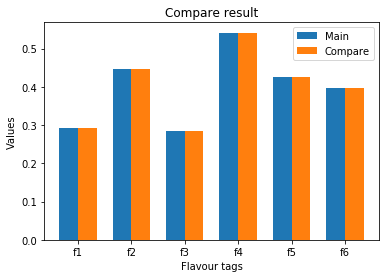

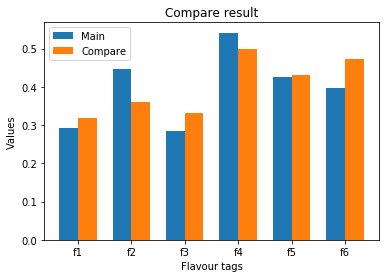

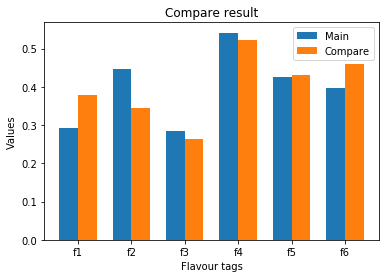

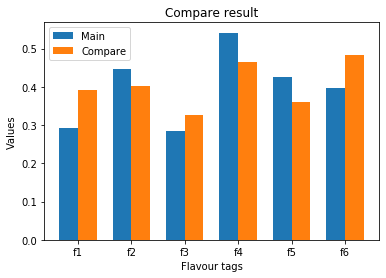

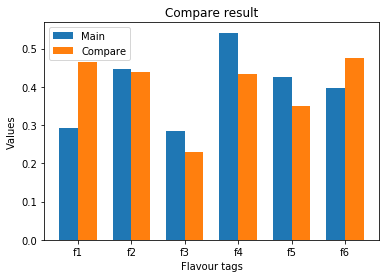

In [65]:
for item in dum:
    plot_results(entry_record, item)

## Evaluation method

In [66]:
def evaluation(df, id_entry, list_liquors):
    entry_data = np.array(df.iloc[id_entry][['score', 'f1', 'f2', 'f3',
                                             'f4', 'f5', 'f6']])
    mse = 0
    for item in list_liquors:
        e = np.subtract(np.array(item), entry_data)
        mse += (e**2)
    
#     print(mse)
    return mse.sum()/len(list_liquors)

In [67]:
sum_mse = 0

for i in df_filling.index.values:
    list_liquors = find_similarities(df_filling, i, del_sequel=False, verbose=False)
    mse = evaluation(df_filling, i, list_liquors)
    sum_mse += mse

print('Mean square error ---- {}'.format(sum_mse))

Mean square error ---- 55.64135259770386


In [294]:
# df_filling.index.values

In [281]:
# import time

# start = time.time()
# loaded_model = pickle.load(open('knn_pickle_file', 'rb'))
# print(time.time() - start)

In [146]:
# df_initial[df_initial.f1.duplicated() & df_initial.flavour_tags.duplicated()]

In [267]:
66.73148450932004/1072/6

0.010374919855304733